In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
data_train = pd.read_csv('dataset_taxi_passenger.csv')
data_train.head()

,Unnamed: 0,timestamp,value
0,0,2014-07-01 00:00:00,10844
1,1,2014-07-01 00:30:00,8127
2,2,2014-07-01 01:00:00,6210
3,3,2014-07-01 01:30:00,4656
4,4,2014-07-01 02:00:00,3820


In [ ]:
data_train.shape

(10320, 3)

# Exploratory Data Analysis

In [ ]:
data_train.isnull().sum()

Unnamed: 0    0
timestamp     0
value         0
dtype: int64

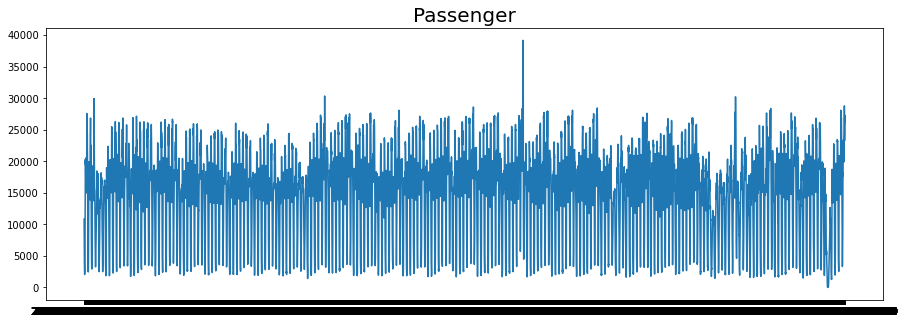

In [ ]:
dates = data_train['timestamp'].values
passe  = data_train['value'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, passe)
plt.title('Passenger',
          fontsize=20);

# Data Pre-Processing

In [ ]:
data_train = data_train.astype({"value": float})

In [ ]:
data_train.dtypes

Unnamed: 0      int64
timestamp      object
value         float64
dtype: object

In [ ]:
passenger = data_train['value'].values
passenger

array([10844.,  8127.,  6210., ..., 27309., 26591., 26288.])

In [ ]:
passenger_new = passenger.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
min_max_scaler = StandardScaler()
passenger = min_max_scaler.fit_transform(passenger_new)

In [ ]:
passenger = passenger.flatten()
passenger

array([-0.61874487, -1.01029084, -1.28654908, ...,  1.75402085,
        1.65055011,  1.60688488])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(passenger, test_size=0.2,shuffle=False)

In [ ]:
X_train.shape

(8256,)

In [ ]:
X_test.shape

(2064,)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

# Model Selection

In [ ]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=128, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=128, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    ])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=(test_set), epochs=100)

Epoch 1/100
65/65 [==============================] - 9s 29ms/step - loss: 0.4484 - mae: 0.8306 - val_loss: 0.4669 - val_mae: 0.8404
Epoch 2/100
65/65 [==============================] - 1s 20ms/step - loss: 0.4382 - mae: 0.8166 - val_loss: 0.4626 - val_mae: 0.8345
Epoch 3/100
65/65 [==============================] - 1s 19ms/step - loss: 0.4337 - mae: 0.8107 - val_loss: 0.4601 - val_mae: 0.8311
Epoch 4/100
65/65 [==============================] - 1s 20ms/step - loss: 0.4306 - mae: 0.8064 - val_loss: 0.4582 - val_mae: 0.8284
Epoch 5/100
65/65 [==============================] - 1s 20ms/step - loss: 0.4277 - mae: 0.8025 - val_loss: 0.4567 - val_mae: 0.8262
Epoch 6/100
65/65 [==============================] - 1s 21ms/step - loss: 0.4259 - mae: 0.8000 - val_loss: 0.4554 - val_mae: 0.8243
Epoch 7/100
65/65 [==============================] - 1s 19ms/step - loss: 0.4236 - mae: 0.7969 - val_loss: 0.4540 - val_mae: 0.8224
Epoch 8/100
65/65 [==============================] - 1s 21ms/step - loss: 0.

# MAE Treshold 

In [ ]:
threshold_mae = (passenger.max() - passenger.min()) * 10/100

In [ ]:
print(threshold_mae)

0.5647513870430447
